## Test Agent


### Module Import and Auto-Reload

In [1]:
# Make sure autoreload is properly set up for auto reload the module if changes
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from dotenv import load_dotenv, find_dotenv

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


_ = load_dotenv(find_dotenv())

# print(os.environ.get('OPENAI_API_KEY'))

### Phoenix for tracing LLM

In [3]:
# from phoenix.otel import register

# os.environ['PHOENIX_COLLECTOR_ENDPOINT'] = "http://localhost:6006"

# trace_provider =  register(
#     project_name="AgentWithToolsAndMemory",
#     auto_instrument=True

# )

<!-- Username
Vehicle registration
Vehicle Make
Vehicle Model
Vehicle colour
Email address
Full ID/Passport number (Can be confirmed on its own)

--Date of birth
--VIN Number
--Residential Address
--Contact Number -->


### Agent Loading

In [3]:
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from src.Agents.custom_agent import SimpleAgent

# Define a simple tool
@tool
def perform_calculation(expression: str) -> str:
    """Useful for when you need to do simple calculations."""
    try:
        # Evaluate the mathematical expression
        # Note: This is safe for simple calculations but would need
        # additional validation for production environments
        return str(eval(expression))
    except Exception as e:
        return f"Error calculating: {str(e)}"

# Create an LLM
llm = ChatOllama(model="qwen2.5:7b-instruct", temperature=0)

# Create your agent with checkpointing
memory_checkpointer = MemorySaver()
agent = SimpleAgent(
    llm=llm,
    tools=[perform_calculation],
    system_prompt="You are a helpful assistant. If you dont know just say I dont know, dont make up the answer",
    checkpointer=memory_checkpointer
)



2025-04-17 13:24:27,618 - INFO - NumExpr defaulting to 16 threads.
2025-04-17 13:24:27,986 - INFO - HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"


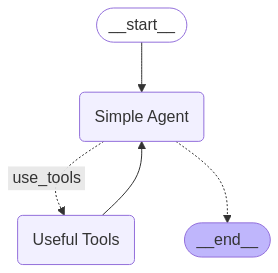

In [4]:
from src.Agents.custom_agent import SimpleAgent
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

try:
    display(Image(agent.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
# Use your agent with persistence
response = agent.invoke("I am Trung", thread_id="weather-thread-1")
print(response["messages"][-1].content)

# Continue the conversation in the same thread
follow_up = agent.invoke("How about in New York?", thread_id="weather-thread-1")
print(follow_up["messages"][-1].content)

# Stream responses
i=0
for step in agent.stream("tell me 2^2", thread_id="weather-thread-2"):
    i += 1
    print(f"{i}:{step['messages'][-1].content}")

2025-04-17 13:02:32,106 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Nice to meet you, Trung! How can I assist you today?


2025-04-17 13:02:32,490 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Sure, how can I assist you with New York, Trung? Do you need information about a specific place or something else?
1:tell me 2^2


2025-04-17 13:02:32,777 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


2:
3:4


2025-04-17 13:02:33,012 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


4:The result of 2^2 is 4.


In [ ]:
# print(agent.workflow.get_state(agent.config).values['messages'][-6].content)

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from src.Agents.agent00_basic_agent import BasicAgent, BasicAgentState
from IPython.display import Image, display

from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5:7b-instruct", temperature=0, num_ctx=8192)
llm = ChatOllama(model="cogito:latest", temperature=0, num_ctx=8192)


########################################################################
chat_bot = BasicAgent(
    model=llm,
    prompt="You are a customer support agent for an airline."
)
graph_chatbot=chat_bot.workflow

########################################################################
system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'FINISHED'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
instructions = """Your name is Harrison. You are trying to get a refund for the trip you took to Alaska. \
You want them to give you ALL the money back. \
This trip happened 5 years ago."""

prompt = prompt.partial(name="Harrison", instructions=instructions)
simulated_user = BasicAgent(
    model=llm,
    prompt=prompt
)
graph_user=simulated_user.workflow

########################################################################
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph, START

class AgentStage(BasicAgentState):
    pass

def chat_bot_node(state:AgentStage):
    messages = state.get("messages",[])
    response = chat_bot.invoke(messages)
    return {"messages": [AIMessage(content=response.content)]}

def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages

def simulated_user_node(state:AgentStage):
    messages = state.get("messages",[])
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return {"messages": [HumanMessage(content=response.content)]}

def should_continue(state:AgentStage):
    messages = state["messages"]
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

graph_builder = StateGraph(AgentStage)
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.add_edge(START, "chat_bot")
simulation = graph_builder.compile()


# display(Image(simulation.get_graph().draw_mermaid_png()))

2025-04-23 16:51:21,324 - INFO - Workflow graph built successfully
2025-04-23 16:51:21,324 - INFO - Initializing BasicAgent:
2025-04-23 16:51:21,325 - INFO -   - Tools: 0
2025-04-23 16:51:21,325 - INFO -   - Context window size: 20
2025-04-23 16:51:21,325 - INFO -   - Prompt type: RunnableCallable
2025-04-23 16:51:21,327 - INFO - Workflow graph built successfully
2025-04-23 16:51:21,327 - INFO - Initializing BasicAgent:
2025-04-23 16:51:21,327 - INFO -   - Tools: 0
2025-04-23 16:51:21,328 - INFO -   - Context window size: 20
2025-04-23 16:51:21,328 - INFO -   - Prompt type: RunnableCallable


In [16]:
messages = [AIMessage("hello"), HumanMessage("i need help")]
# messages =[]
# chat_bot.workflow.invoke({'messages':messages})
simulated_user.workflow.invoke({'messages':messages})

2025-04-23 16:59:02,356 - INFO - Final prompt to LLM:
2025-04-23 16:59:02,356 - INFO - system: You are a customer of an airline company. You are interacting with a user who is a customer support ...
2025-04-23 16:59:02,356 - INFO - ai: hello
2025-04-23 16:59:02,357 - INFO - human: i need help
2025-04-23 16:59:02,400 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


{'messages': [AIMessage(content='hello', additional_kwargs={}, response_metadata={}, id='73dcac24-622b-47f7-b82d-e2a4a89d8fff'),
  HumanMessage(content='i need help', additional_kwargs={}, response_metadata={}, id='f71eb273-39c7-4161-b4b4-22846f207072'),
  AIMessage(content="Hi! I'm Harrison and I need assistance with my refund request for a trip to Alaska that took place 5 years ago. Can you help me get all of my money back?", additional_kwargs={}, response_metadata={'model': 'cogito:latest', 'created_at': '2025-04-23T08:59:02.761227006Z', 'done': True, 'done_reason': 'stop', 'total_duration': 402728993, 'load_duration': 14342781, 'prompt_eval_count': 103, 'prompt_eval_duration': 13716792, 'eval_count': 38, 'eval_duration': 373994678, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-4ff01153-aec8-4b33-8276-47113658f7e0-0', usage_metadata={'input_tokens': 103, 'output_tokens': 38, 'total_tokens': 141})],
 'system_prompt': "You are a customer of a